# Introduction to Statistical Learning Exercises 3 - Linear Regression

This post is the second in a series where I work through [Intro to Statistical Learning](https://www.statlearning.com/) in python instead of R as done in the text. In this post I'll work through the exercises for chapter 3, on linear regression. The second edition is coming in summer 2021, but I'm working through the first edition. You can find a free PDF [here](https://www.statlearning.com/s/ISLRSeventhPrinting.pdf).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.outliers_influence as st_inf
from statsmodels.graphics.regressionplots import abline_plot
from IPython.display import display, Markdown
%matplotlib inline

In [2]:
def printm(input_str):
    display(Markdown(input_str))

## Conceptual

### #1 
*Describe the null hypotheses to which the p-values given in Table 3.4
correspond. Explain what conclusions you can draw based on these
p-values. Your explanation should be phrased in terms of sales, TV,
radio, and newspaper, rather than in terms of the coefficients of the
linear model.*

In [3]:
df = pd.read_csv("../data/Advertising.csv", index_col=0)
print(sm.OLS(df["Sales"], sm.add_constant(df[["TV", "Radio", "Newspaper"]])).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Sat, 15 May 2021   Prob (F-statistic):           1.58e-96
Time:                        16:20:42   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9389      0.312      9.422      0.0

For each coefficient the null hypothesis is that the true population parameter is zero. That is, there is no impact on the expected value of sales for an observed change in the amount of advertising spent on TV/Radio/Newspaper.

The coefficient on the intercept is positive, that is we expect that there will be some sales even in the absence of advertising. The p value is very close to 0, which means that based on the observed data it is very unlikely we would observe that coefficient from a sample, if the true average sales in absence of advertising was zero.

For both TV and radio, the coefficient is positive and the p value is very close to zero. based on this, if we observe a higher level of TV or radio advertising, we should expect a higher level of sales. 

For newspaper advertising the coefficient is slightly negative, but the p value is large. Based on this we cannot reject the null hypothesis that observing a change in newspaper advertising provides no meaningful information on the expected level of sales.

### #2
*Carefully explain the differences between the KNN classifier and KNN
regression methods.*

In general, classification models are concerned with associating an observation with a discrete category, whereas regression uses and observation to predict a continuous value.

KNN models use known values of nearby observations to predict an unknown value, where "nearby" is determined by the other characteristics of the observation in the model. 

For classification this leads to ranges of values where a majority of the K nearest observations belong to a class. Any unknown observations in that range will be predicted to be in that class. For regression the result is a weighted average of the value of the nearest neighbors.

### #3
Suppose we have a data set with five predictors, $X_1$ = GPA, $X_2$ = IQ, $X_3$ = Gender (1 for Female and 0 for Male), $X_4$ = Interaction between GPA and IQ, and $X_5$ = Interaction between GPA and Gender. The  response is starting salary after graduation (in thousands of dollars). Suppose we use least squares to fit the model, and get $\beta_0$ = 50, $\beta_1$ = 20, $\beta_2$ = 0.07, $\beta_3$ = 35, $\beta_4$ = 0.01, $\beta_5\$ = −10.


(a) Which answer is correct, and why?

i. For a fixed value of IQ and GPA, males earn more on average than females.

ii. For a fixed value of IQ and GPA, females earn more on average than males.

iii. For a fixed value of IQ and GPA, males earn more on average than females provided that the GPA is high enough.

iv. For a fixed value of IQ and GPA, females earn more on average than males provided that the GPA is high enough.

(b) Predict the salary of a female with IQ of 110 and a GPA of 4.0.

(c) True or false: Since the coefficient for the GPA/IQ interaction term is very small, there is very little evidence of an interaction effect. Justify your answer.

(a)
$X_3 = 1$ For females and $\beta_3 = 35$, $\beta_5 = -10$, which is going to be multiplied by GPA in the case of females.
For GPA < 3.5 The combined impact is positive, for GPA = 3.5 there is no gender differential predicted, and for GPA > 3.5 the combined impact is negative.
Therefore iii. is correct

(b)
$\text{salary} = \beta_0 + \beta_1 \text{GPA} + \beta_2 \text{IQ} + \beta_3 \text{Gender} + \beta_4 \text{GPAxIQ} + \beta_5{GPAxGender}$

$\text{salary} = 50 + (20 * 4) + (20 * 110) + 35 + (0.01 * 4 * 110) + (-10 * 4)$

In [4]:
50 + (20 * 4) + (20 * 110) + 35 + (0.01 * 4 * 110) + (-10 * 4)

2329.4

(c)
A small coefficient size may indicate that the effect is not of large practical significance (although it could be if the independent variable it operates on is typically large relative to the dependent variable). To determine statistical significance it is necessary to know the standard error of the coefficient. We have insufficient evidence to evaluate statistical significance just from the point parameter estimate.

### #4

I collect a set of data (n = 100 observations) containing a single predictor and a quantitative response. I then fit a linear regression model to the data, as well as a separate cubic regression, i.e. $Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \epsilon$.

(a) Suppose that the true relationship between X and Y is linear, i.e. $Y = \beta_0 + \beta_1 X + \epsilon$. Consider the training residual sum of squares (RSS) for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.

In [5]:
printm("(a) Let's find out: ")
intercept = np.ones(100) * 10
# Just make beta 1 = 1 for simplicity
X_train = np.random.rand(100) * 100
noise_train = np.random.normal(0, 5, 100)
X_train_sq = X_train**2
X_train_cube = X_train**3
y_train = intercept + X_train + noise_train
ols_linear = sm.OLS(y_train, sm.add_constant(X_train)).fit()
ols_poly = sm.OLS(y_train, sm.add_constant(np.vstack([X_train, X_train_sq, X_train_cube]).T)).fit()
printm(f"Linear RSS: {ols_linear.ssr:0.4}")
printm(f"Polynomial RSS: {ols_poly.ssr:0.4}")

(a) Let's find out: 

Linear RSS: 2.088e+03

Polynomial RSS: 2.082e+03

The polynomial terms are fitting to some of the noise, so on the data it's trained on the model has a slightly better fit.

(b) Answer (a) using test rather than training RSS.

In [6]:
printm("(b)")
X_test = np.random.rand(100) * 100
noise_test = np.random.normal(0, 5, 100)
X_test_sq = X_test**2
X_test_cube = X_test**3
y_test = intercept + X_test + noise_test
y_pred_lin = ols_linear.predict(sm.add_constant(X_test))
resid_lin = y_test - y_pred_lin
rss_lin = (resid_lin**2).sum()
y_pred_poly = ols_poly.predict(sm.add_constant(np.vstack([X_test, X_test_sq, X_test_cube]).T))
resid_poly = y_test - y_pred_poly
rss_poly = (resid_poly**2).sum()
printm(f"Linear test RSS: {rss_lin:0.4}\nPolynomial RSS: {rss_poly:0.4}")

(b)

Linear test RSS: 2.222e+03
Polynomial RSS: 2.209e+03

Since the estimated relationships on the polynomial terms was spurious, when you get to a new set of data the model performs worse with them included.

(c) Suppose that the true relationship between X and Y is not linear, but we don’t know how far it is from linear. Consider the training RSS for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not
enough information to tell? Justify your answer.

(d) Answer (c) using test rather than training RSS.

We saw above that even if there's no non-linear component to the model, adding extra terms will get you a better fit on your training set. Given that we are now assuming there is at least a small bit of information captured in the non-linear component of the relationship, the training RSS for the cubic regression will clearly be lower.

On the test data it will depend on the degree of non-linearity. If it's a particularly weak relationship you could see the same sort of overfitting pattern as in part b dominate the weak additional information in the non-linear component. If it's a strong non-linearity then the polynomial model should perform better even on test data. Where strong is a measure of the degree of non-linearity relative to the amount of noise in the model.

### #5

Consider the fitted values that result from performing linear regression without an intercept. In this setting, the $i$th fitted value takes the form
$\hat{y}_i = x_i\hat{\beta}$

Where:
$$\hat{\beta} = \frac{\sum_{i=1}^{n}x_i y_i}{\sum_{j=1}^{n}x^2_{j}}$$
Show that we can write:
$$\hat{y_i}=\sum_{j=1}^{n}a_{j}y_{j}$$

What is $a_{j}$?

Note: We interpret this result by saying that the fitted values from linear regression are linear combinations of the response values.

$$\hat{y}_i = x_i\hat{\beta}$$

$$\hat{\beta} = \frac{\sum_{i=1}^{n}x_i y_i}{\sum_{j=1}^{n}x^2_{j}}$$

$$\hat{y}_i = x_i \frac{\sum_{j=1}^{n}x_j y_j}{\sum_{k=1}^{n}x^2_{k}}$$

$$\hat{y}_i = x_i \sum_{j=1}^{n}\frac{x_j y_j}{\sum_{k=1}^{n}x^2_{k}}$$

$$\hat{y}_i =  \sum_{j=1}^{n}\frac{x_i x_j}{\sum_{k=1}^{n}x^2_{k}} y_j$$

$$a_j = \frac{x_i x_j}{\sum_{k=1}^{n}x^2_{k}}$$

### #6

Using (3.4), argue that in the case of simple linear regression, the least squares line always passes through the point $(\bar{x}, \bar{y})$.

3.4:

$$\hat{\beta_1} = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^n (x_i - \bar{x})^2}$$

$$\hat{\beta_0} = \bar{y} - \hat{\beta_1} \bar{x}$$

Least squares line:
$$\hat{y_i} = \hat{\beta_0} + \hat{\beta_1}x_i$$

Need to show that for $x_i = \bar{x}$ that $y_i = \bar{y}$

Let $x_i = \bar{x}$

$$\hat{y_i} = \hat{\beta_0} + \hat{\beta_1}\bar{x}$$

$$\hat{y_i} = \bar{y} - \hat{\beta_1}\bar{x} + \hat{\beta_1}\bar{x} = \bar{y}$$

### #7

It is claimed in the text that in the case of simple linear regression of Y onto X, the $R^2$ statistic (3.17) is equal to the square of the correlation between X and Y (3.18). Prove that this is the case. For simplicity, you may assume that $\bar{x} = \bar{y} = 0$.

3.17:

$$ R^2 = 1 - \frac{\text{RSS}}{\text{TSS}}$$

$$ \text{RSS} = \sum_{i=1}^n(y_i - \hat{y_i})^2 = \sum_{i=1}^n(y_i - \hat{\beta_0} - \hat{\beta_1}x_i)^2 = \sum_{i=1}^n(y_i - \hat{\beta_0} - \frac{\sum_{j=1}^n (x_j - \bar{x})(y_j - \bar{y})}{\sum_{j=1}^n (x_j - \bar{x})^2} x_i)^2 $$

$$ \text{TSS} = \sum_{i=1}^n(y_i - \bar{y})^2$$

3.18:

$$\text{CORR}(X, Y) = \frac{\sum_{i=1}^n(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^n(x_i - \bar{x})^2}\sqrt{\sum_{i=1}^n(y_i - \bar{y})^2}}$$

Simplifying with $\bar{x} = \bar{y} = 0$:

$$\beta_0 = \bar{y} - \bar{\beta_1}\bar{x} = 0$$

$$\beta_1 = \frac{\sum_{i=1}^n x_i y_i}{x_i^2}$$


$$R^2 = \frac{\sum_{i=1}^ny_i^2 - \sum_{i=1}^n(y_i - \hat{\beta_0} - \frac{\sum_{j=1}^n (x_j - \bar{x})(y_j - \bar{y})}{\sum_{j=1}^n (x_j - \bar{x})^2} x_i)^2}{\sum_{i=1}^ny_i^2}$$

Writing latex to do math is terrible. Worked the rest out on paper

## Applied

### #8

This question involves the use of simple linear regression on the Auto data set.

(a) Use the lm() function to perform a simple linear regression with mpg as the response and horsepower as the predictor. Use the summary() function to print the results. Comment on the output.

For example:

i. Is there a relationship between the predictor and the response?

ii. How strong is the relationship between the predictor and the response?

iii. Is the relationship between the predictor and the response positive or negative?

iv. What is the predicted mpg associated with a horsepower of 98? What are the associated 95 % confidence and prediction intervals?

(b) Plot the response and the predictor. Use the abline() function to display the least squares regression line.

(c) Use the plot() function to produce diagnostic plots of the least squares regression fit. Comment on any problems you see with the fit.

In [7]:
df = sm.datasets.get_rdataset("Auto", "ISLR", cache=True).data

In [8]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
1,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
2,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
3,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
4,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
5,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [9]:
y_train = df["mpg"]
X_train = sm.add_constant(df["horsepower"])
lm = sm.OLS(y_train, X_train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Sat, 15 May 2021   Prob (F-statistic):           7.03e-81
Time:                        16:20:42   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.0

i) The model does find a relationship between mpg and horsepower. Looking at the standard error and p-value it is statistically significant.

ii) The p value is very close to 0, so there's a strong relationship from a statistical perspective, how strong it is from a practical perspective is hard to interpret without knowing about the range of values for mpg and horsepower, which I'll see when I do the plots in a later part of this question.

iii) There's a negative relationship, higher horsepower is associated with lower miles per gallon.

iv) See code below

In [10]:
lm.get_prediction((1, 98)).summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,24.467077,0.251262,23.973079,24.961075,14.809396,34.124758


b)

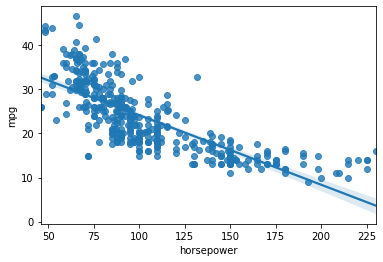

In [11]:
sns.regplot(x="horsepower", y="mpg", data=df);

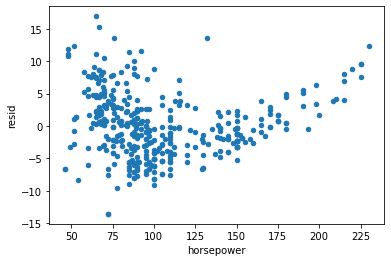

In [12]:
result_df = df[["horsepower", "mpg"]].copy()
result_df["fitted"] = lm.fittedvalues
result_df["resid"] = lm.resid
result_df.plot(x="horsepower", y="resid", kind="scatter");

There's a pretty clear non-linear pattern in the fit. Residuals are high at low and high horsepower. Adding in horsepower squared might help.

### #9 

This question involves the use of multiple linear regression on the Auto data set.

(a) Produce a scatterplot matrix which includes all of the variables in the data set.

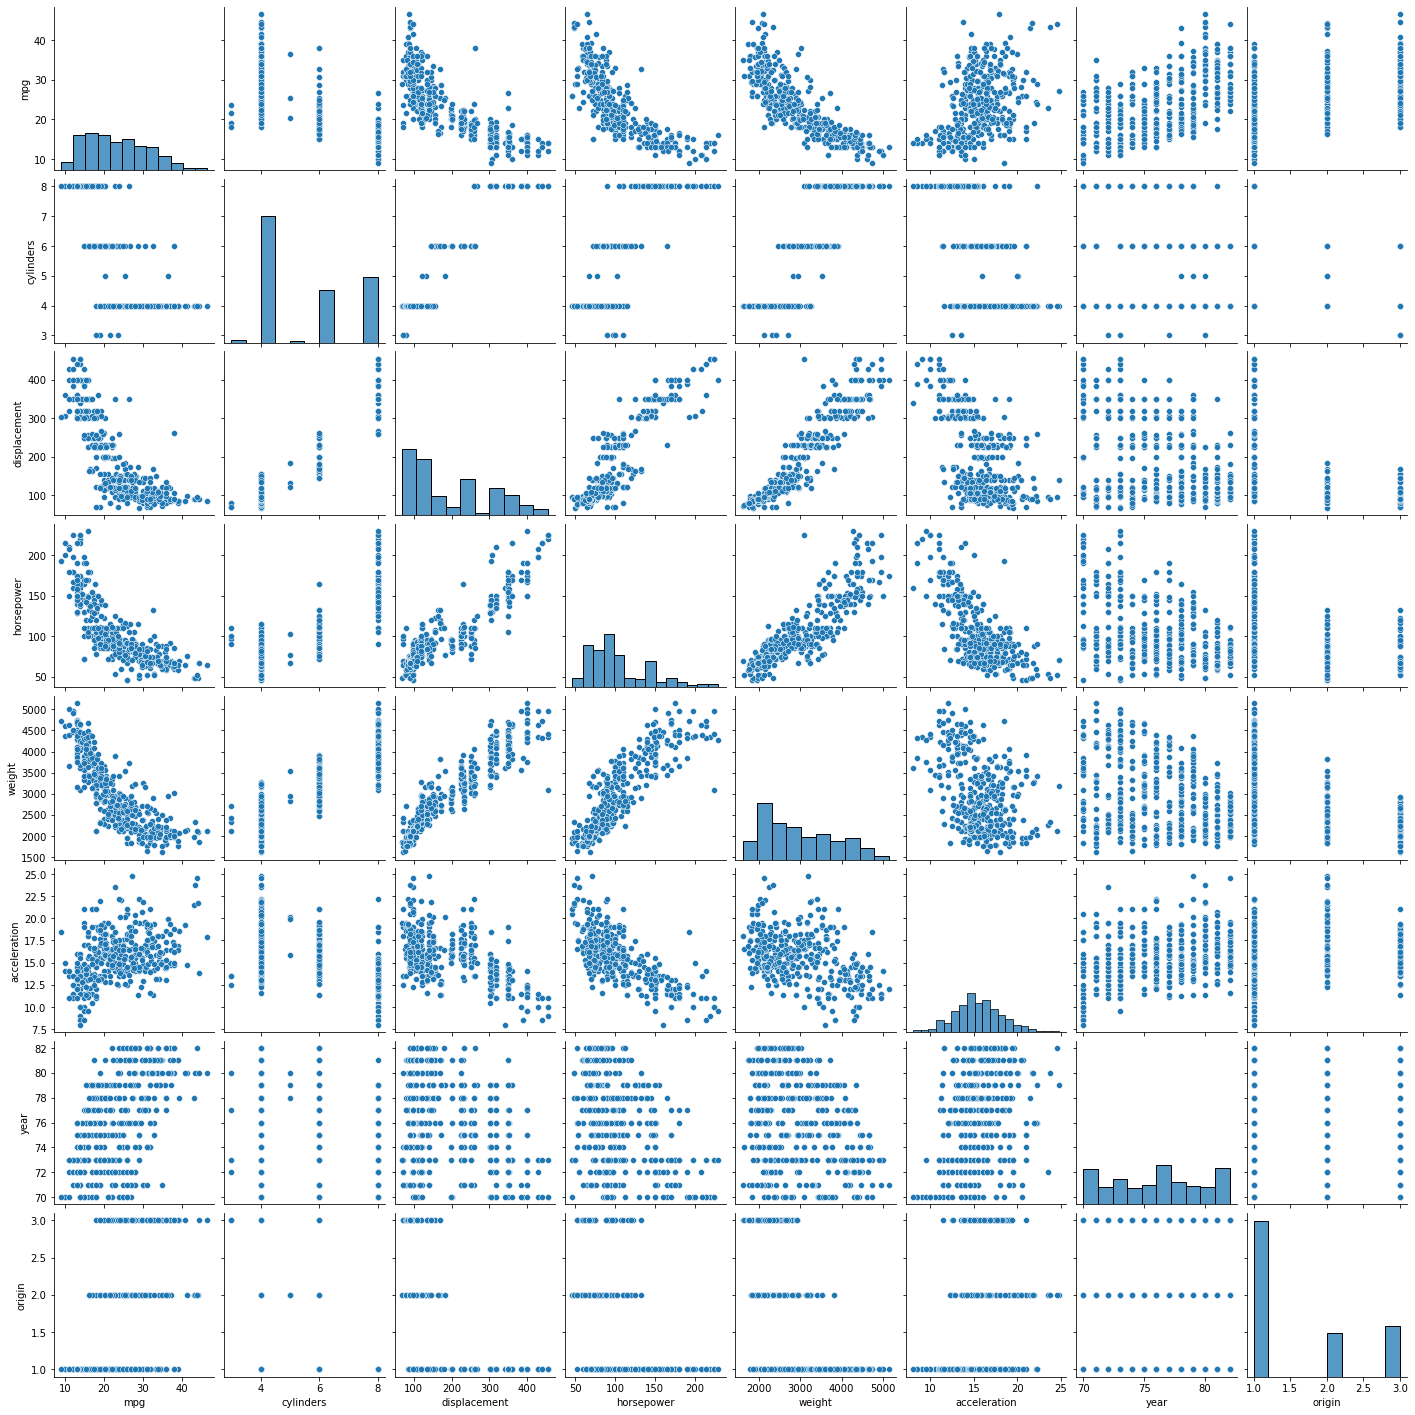

In [13]:
sns.pairplot(df);

(b) Compute the matrix of correlations between the variables using the function cor() . You will need to exclude the name variable, which is qualitative.

In [14]:
df.corr().style.background_gradient(cmap='viridis')

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


(c) Use the lm() function to perform a multiple linear regression with mpg as the response and all other variables except name as the predictors. Use the summary() function to print the results.

In [15]:
y_train = df["mpg"]
X_train = sm.add_constant(pd.concat([df.drop(columns=["mpg", "name", "origin"]), pd.get_dummies(df["origin"], drop_first=True, prefix="origin")], axis="columns"))
lm = sm.OLS(y_train, X_train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     224.5
Date:                Sat, 15 May 2021   Prob (F-statistic):          1.79e-139
Time:                        16:20:51   Log-Likelihood:                -1020.5
No. Observations:                 392   AIC:                             2059.
Df Residuals:                     383   BIC:                             2095.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -17.9546      4.677     -3.839   

Comment on the output. For instance:

i. Is there a relationship between the predictors and the response?

ii. Which predictors appear to have a statistically significantcrelationship to the response?

iii. What does the coefficient for the year variable suggest?

There is a relationship between the independent variables and the dependent variable. Of them, displacement, weight, year, and origin are statistically signficant. The positive coefficient on year suggests that mileage is improving over time, holding the other observable characteristics constant.

(d) Use the plot() function to produce diagnostic plots of the linear regression fit. Comment on any problems you see with the fit. Do the residual plots suggest any unusually large outliers? Does the leverage plot identify any observations with unusually high leverage?

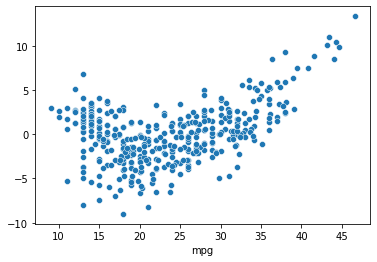

In [16]:
y_true = df["mpg"]
resid = lm.resid
y_pred = lm.predict(X_train)
sns.scatterplot(x=y_true, y=resid);

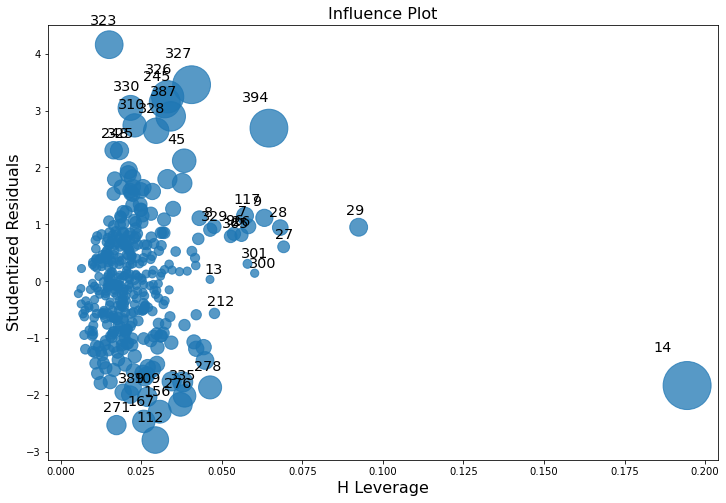

In [17]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(lm, ax=ax, criterion="cooks")

The residual plot shows there's still some non linearity, with larger residuals concentrated at low, and particularly at high mpg. The influence plot shows that observation 14 is a clear outlier in terms of leverage.

(e) Use the * and : symbols to fit linear regression models with interaction effects. Do any interactions appear to be statistically significant?

In [18]:
y_train = df["mpg"]
X_train = (
    pd.concat([df.drop(columns=["mpg", "name", "origin"]), pd.get_dummies(df["origin"], drop_first=True, prefix="origin")], axis="columns")
    .assign(cylinders_x_weight=lambda df: df["cylinders"] * df["weight"])
    .assign(cylinders_x_displacement=lambda df: df["cylinders"] * df["displacement"])
    .assign(horsepower_x_weight=lambda df: df["horsepower"] * df["weight"])
    .assign(horsepower_x_acceleration=lambda df: df["horsepower"] * df["acceleration"])
    .pipe(sm.add_constant)
)
lm = sm.OLS(y_train, X_train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     207.4
Date:                Sat, 15 May 2021   Prob (F-statistic):          2.99e-158
Time:                        16:20:52   Log-Likelihood:                -964.52
No. Observations:                 392   AIC:                             1955.
Df Residuals:                     379   BIC:                             2007.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Cylinders * weight is significant at the 10% confidence level, but not at 5. Cylinders * displacement is not significant. Horsepower * weight and acceleration are both significant. Adjusted $R^2$ has increased from about 0.82 to about 0.86, so model fit overall has improved. 

(f) Try a few different transformations of the variables, such as $\log{X}$, $\sqrt{X}$, $X^2$. Comment on your findings.

In [19]:
y_train = df["mpg"]
X_train = (
    pd.concat([df.drop(columns=["mpg", "name", "origin"]), pd.get_dummies(df["origin"], drop_first=True, prefix="origin")], axis="columns")
    .assign(weight_sq=lambda df: df["weight"]**2)
    .pipe(sm.add_constant)
)
lm = sm.OLS(y_train, X_train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     256.7
Date:                Sat, 15 May 2021   Prob (F-statistic):          5.17e-156
Time:                        16:20:52   Log-Likelihood:                -978.43
No. Observations:                 392   AIC:                             1977.
Df Residuals:                     382   BIC:                             2017.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1291      4.613      0.028   

In [20]:
y_train = df["mpg"]
X_train = (
    pd.concat([df.drop(columns=["mpg", "name", "origin"]), pd.get_dummies(df["origin"], drop_first=True, prefix="origin")], axis="columns")
    .assign(log_weight=lambda df: np.log(df["weight"]))
    .drop(columns="weight")
    .pipe(sm.add_constant)
)
lm = sm.OLS(y_train, X_train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     268.7
Date:                Sat, 15 May 2021   Prob (F-statistic):          5.74e-152
Time:                        16:20:52   Log-Likelihood:                -990.93
No. Observations:                 392   AIC:                             2000.
Df Residuals:                     383   BIC:                             2036.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          135.8479     11.399     11.917   

In [21]:
y_train = df["mpg"]
X_train = (
    pd.concat([df.drop(columns=["mpg", "name", "origin"]), pd.get_dummies(df["origin"], drop_first=True, prefix="origin")], axis="columns")
    .assign(weight_sq=lambda df: df["weight"]**2)
    .assign(horsepower_sq=lambda df: df["horsepower"]**2)
    .pipe(sm.add_constant)
)
lm = sm.OLS(y_train, X_train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     244.2
Date:                Sat, 15 May 2021   Prob (F-statistic):          6.51e-159
Time:                        16:20:52   Log-Likelihood:                -968.64
No. Observations:                 392   AIC:                             1959.
Df Residuals:                     381   BIC:                             2003.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.1970      4.649      1.118

Adding in non-linearities for weight and horsepower definitely help. I'm a little surprised the log transformation fits a bit worse than the linear plus squared transformation but in general it's what I'd expect from having looked at the residuals.

### #10

This question should be answered using the Carseats data set.

In [22]:
text_to_bool = {"Yes": 1, "No": 0}
df = (
    sm.datasets.get_rdataset("Carseats", "ISLR", cache=True).data
    .assign(Urban=lambda df: df["Urban"].map(text_to_bool))
    .assign(US=lambda df: df["US"].map(text_to_bool))
    .pipe(pd.get_dummies, drop_first=True)
    .pipe(sm.add_constant)
)
df.head()

,const,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,Urban,US,ShelveLoc_Good,ShelveLoc_Medium
0,1.0,9.50,138,73,11,276,120,42,17,1,1,0,0
1,1.0,11.22,111,48,16,260,83,65,10,1,1,1,0
2,1.0,10.06,113,35,10,269,80,59,12,1,1,0,1
3,1.0,7.40,117,100,4,466,97,55,14,1,1,0,1
4,1.0,4.15,141,64,3,340,128,38,13,1,0,0,0


(a) Fit a multiple regression model to predict Sales using Price, Urban, and US.

In [23]:
y_train = df["Sales"]
X_train = df[["const", "Price", "Urban", "US"]]
lm = sm.OLS(y_train, X_train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     41.52
Date:                Sat, 15 May 2021   Prob (F-statistic):           2.39e-23
Time:                        16:20:52   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1863.
Df Residuals:                     396   BIC:                             1879.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0435      0.651     20.036      0.0

(b) Provide an interpretation of each coefficient in the model. Be careful—some of the variables in the model are qualitative!

The intercept is interpreted as the predicted sales in a rural, non-US location with a price of zero. Don't take that too literally.
Price has a negative coefficient, indicating that for every unit increase in price we expect about a -0.05 reduction in sales.
Urban has a negative coefficient, which would suggest that urban locations have slightly lower sales, all else equal. However, the coefficient on urban is not significant, so the more accurate interpretation is that there is no evidence that urban vs rural is associated with a change in sales.
US has a positive coefficient, suggesting for a given price a US location will have higher sales by 1.2 than a non-US location.

(c) Write out the model in equation form, being careful to handle the qualitative variables properly.

$$\text{Sales} = 13.0 - 0.05 * \text{Price} -0.02 * \text{is_Urban} + 1.2 * \text{in_US}$$

Not sure what this question was asking for exactly

(d) For which of the predictors can you reject the null hypothesis $H_0: \beta_j = 0$?

As discussed in b, I can reject the null for all but Urban.

(e) On the basis of your response to the previous question, fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.

In [24]:
y_train = df["Sales"]
X_train = df[["const", "Price", "US"]]
lm = sm.OLS(y_train, X_train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     62.43
Date:                Sat, 15 May 2021   Prob (F-statistic):           2.66e-24
Time:                        16:20:52   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1861.
Df Residuals:                     397   BIC:                             1873.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0308      0.631     20.652      0.0

(f) How well do the models in (a) and (e) fit the data?

Both fit pretty poorly. $R^2$ is about 0.24 in each of them, meaning the model is explaining about a quarter of the observed variation in sales. The adjusted $R^2$ in the second model is slightly higher, supporting the idea that removing Urban was the right decision.

(g) Using the model from (e), obtain 95 % confidence intervals for the coefficient(s).

In [25]:
lm.conf_int(alpha=0.05)

,0,1
const,11.79032,14.271265
Price,-0.06476,-0.044195
US,0.69152,1.707766


(h) Is there evidence of outliers or high leverage observations in the model from (e)?

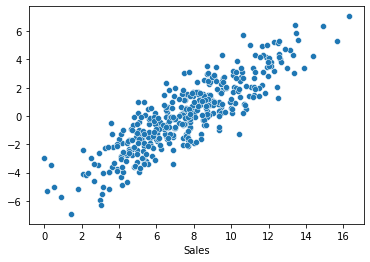

In [26]:
y_true = df["Sales"]
resid = lm.resid
y_pred = lm.predict(X_train)
sns.scatterplot(x=y_true, y=resid);

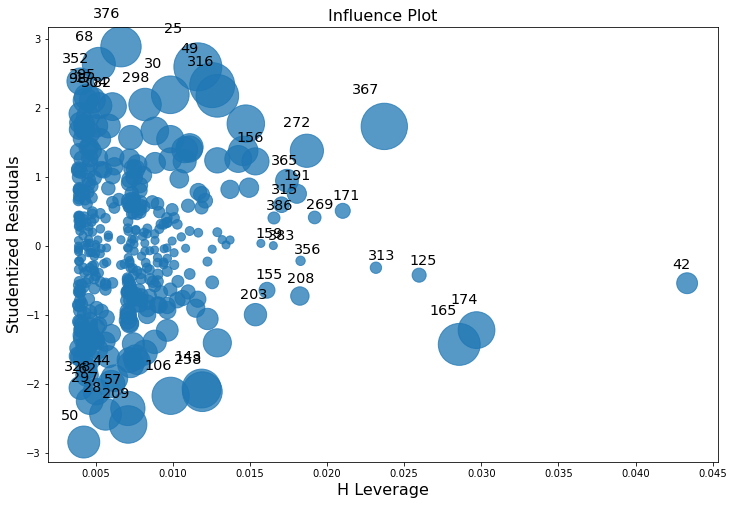

In [27]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(lm, ax=ax, criterion="cooks")

Residuals increase with sales, suggesting we want a log transformation on sales to predict the percent rather than unit change in sales based on the model factors. Observation 42 has fairly high leverage.

### #11

In this problem we will investigate the t-statistic for the null hypothesis $H_0 : \beta = 0$ in simple linear regression without an intercept. To begin, we generate a predictor x and a response y as follows.

In [28]:
x = np.random.normal(size=100)
y = 2*x + np.random.normal(size=100)

a) Perform a simple linear regression of y onto x , without an intercept. Report the coefficient estimate $\hat{\beta}$, the standard error of this coefficient estimate, and the t-statistic and p-value associated with the null hypothesis $H_0 : \beta = 0$. Comment on these results.

In [29]:
lm = sm.OLS(y, x).fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.766
Model:                            OLS   Adj. R-squared (uncentered):              0.764
Method:                 Least Squares   F-statistic:                              324.6
Date:                Sat, 15 May 2021   Prob (F-statistic):                    5.15e-33
Time:                        16:20:52   Log-Likelihood:                         -142.76
No. Observations:                 100   AIC:                                      287.5
Df Residuals:                      99   BIC:                                      290.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The coefficient estimate is 1.94, which is close to the true population parameter 2. The standard error is 0.086 and the associated t-stat and p-value give strong evidence to reject the null hypothesis

b) Now perform a simple linear regression of x onto y without an intercept, and report the coefficient estimate, its standard error, and the corresponding t-statistic and p-values associated with the null hypothesis $H_0 : \beta = 0$. Comment on these results.
c) What is the relationship between the results obtained in (a) and (b)?

In [30]:
lm = sm.OLS(x, y).fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.766
Model:                            OLS   Adj. R-squared (uncentered):              0.764
Method:                 Least Squares   F-statistic:                              324.6
Date:                Sat, 15 May 2021   Prob (F-statistic):                    5.15e-33
Time:                        16:20:52   Log-Likelihood:                         -60.930
No. Observations:                 100   AIC:                                      123.9
Df Residuals:                      99   BIC:                                      126.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The coefficient for y is 0.4317, which is also close to the true population parameter. Remember, if $y = 2x + \epsilon$ then it follows that $x = \frac{y - \epsilon}{2} = \frac{1}{2}y - \frac{1}{2}\epsilon$. The t-statistic and p value are identical to the previous model.

For the regression of Y onto X without an intercept, the t-statistic for $H_0 : \beta = 0$ takes the form $\frac{\hat{\beta}}{SE(\hat{\beta})}$, where $\hat{\beta}$ is
given by (3.38), and where big equation for $SE(\hat{\beta})$ that I don't feel like copying out.

Show algebraically and confirm numerically in python that the t-statistic can be written as


$$\frac{\sqrt{n-1}\sum_i^nx_iy_i}{\sqrt{(\sum_i^nx_i^2)(\sum_i^ny_i^2)-(\sum_i^nx_iy_i)^2}}$$

In [31]:
statsmodels_t = lm.tvalues[0]

root_n_min1 = np.sqrt(len(x) -1)
sum_xy = (x * y).sum()
sum_x_sq = (x**2).sum()
sum_y_sq = (y**2).sum()
t_calc = (root_n_min1 * sum_xy)/(np.sqrt((sum_x_sq * sum_y_sq) - sum_xy**2))
print(f"t-stat from statsmodels: {statsmodels_t:0.3} t-stat from calc: {t_calc:0.3}")

t-stat from statsmodels: 18.0 t-stat from calc: 18.0


e) Using the results from (d), argue that the t-statistic for the regression of y onto x is the same as the t-statistic for the regression of x onto y.

The equation is symmetric. If you swap x and y there's no change to the formula. 

f) In R , show that when regression is performed with an intercept, the t-statistic for $H_0: \beta_1 = 0$ is the same for the regression of y
onto x as it is for the regression of x onto y.

In [32]:
y_x_t = sm.OLS(y, sm.add_constant(x)).fit().tvalues[1]
x_y_t = sm.OLS(x, sm.add_constant(y)).fit().tvalues[1]
print(f"y on x: {y_x_t:0.3}, x on y: {x_y_t:0.3}")

y on x: 17.6, x on y: 17.6


This problem involves simple linear regression without an intercept.

(a) Recall that the coefficient estimate $\hat{\beta}$ for the linear regression of Y onto X without an intercept is given by (3.38). Under what circumstance is the coefficient estimate for the regression of X onto Y the same as the coefficient estimate for the regression of Y onto X?

(b) Generate an example in R with n = 100 observations in which the coefficient estimate for the regression of X onto Y is different from the coefficient estimate for the regression of Y onto X.

(c) Generate an example in R with n = 100 observations in which the coefficient estimate for the regression of X onto Y is the same as the coefficient estimate for the regression of Y onto X.

a)
$$\hat{\beta} = \frac{\sum_i^nx_iy_i}{\sum_i^nx_i^2}$$
so $\hat{\beta}$ will be the same if $x_i^2 = y_i^2$ so $y = x$ or $y = -x$

b) I just did that above

c)

In [33]:
x = np.arange(start=0, stop=100, step=1)
y = -x + np.random.normal(size=100)
lmx = sm.OLS(x, y).fit()
lmy = sm.OLS(y, x).fit()
print(lmx.summary())
print(lmy.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          3.748e+05
Date:                Sat, 15 May 2021   Prob (F-statistic):                   5.96e-179
Time:                        16:20:52   Log-Likelihood:                         -134.76
No. Observations:                 100   AIC:                                      271.5
Df Residuals:                      99   BIC:                                      274.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### #13
In this exercise you will create some simulated data and will fit simple linear regression models to it

 (a)Using the rnorm() function, create a vector, x , containing 100 observations drawn from a N (0, 1) distribution. This represents
a feature, X.

(b) Using the rnorm() function, create a vector, eps , containing 100 observations drawn from a N (0, 0.25) distribution i.e. a normal
distribution with mean zero and variance 0.25.

(c) Using x and eps , generate a vector y according to the model $Y = −1 + 0.5X + \epsilon$

What is the length of the vector y ? What are the values of $\beta_0$ and $\beta_1$ in this linear model?

Create a scatterplot displaying the relationship between x and y . Comment on what you observe.

(e) Fit a least squares linear model to predict y using x . Comment on the model obtained. How do $\hat{\beta_0}$ and $\hat{\beta_1}$ compare to $\beta_0$ and $\beta_1$?

(f) Display the least squares line on the scatterplot obtained in (d). Draw the population regression line on the plot, in a different
color. Use the legend() command to create an appropriate legend.

(g) Now fit a polynomial regression model that predicts $y$ using $x$ and $x^2$. Is there evidence that the quadratic term improves the
model fit? Explain your answer.

(h) Repeat (a)–(f) after modifying the data generation process in such a way that there is less noise in the data. The model (3.39)
should remain the same. You can do this by decreasing the variance of the normal distribution used to generate the error term $\epsilon$ in (b). Describe your results.

(i) Repeat (a)–(f) after modifying the data generation process in such a way that there is more noise in the data. The model (3.39) should remain the same. You can do this by increasing the variance of the normal distribution used to generate the error term $\epsilon$ in (b). Describe your results.

In [34]:
def q_15(noise_var):
    x = np.random.normal(loc=0.0, scale=1.0, size=100)
    eps = np.random.normal(loc=0, scale=np.sqrt(noise_var), size=100)
    y = (0.5 * x) - 1 + eps
    printm(f"regardless of $\epsilon$, $beta_0 = -1$ and $beta_1 = 0.5$ and $y$ is a vector of length {len(y)}")
    printm("Simple Linear Regression")
    lm = sm.OLS(y, sm.add_constant(x)).fit()
    print(lm.summary())
    
    fig, ax = plt.subplots()
    sns.scatterplot(x=x, y=y, ax=ax)
    abline_plot(model_results=lm, ax=ax)
    # figure out points for true regression line
    left, right = plt.xlim()
    line_seg = mlines.Line2D([left, right], [(0.5*left -1), (0.5*right) -1], color='red')
    red_patch = mpatches.Patch(color="red", label="Population line")
    blue_patch = mpatches.Patch(color="blue", label="Regression line")
    plt.legend(handles=[red_patch, blue_patch])
    ax.add_line(line_seg)
    plt.show()
    plt.close()
    x_sq = x**2
    pr = sm.OLS(y, sm.add_constant(np.vstack([x, x_sq]).T)).fit()
    printm("Polynomial regression: ")
    print(pr.summary())

a through g:

regardless of $\epsilon$, $beta_0 = -1$ and $beta_1 = 0.5$ and $y$ is a vector of length 100

Simple Linear Regression

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     108.1
Date:                Sat, 15 May 2021   Prob (F-statistic):           1.68e-17
Time:                        16:20:53   Log-Likelihood:                -58.454
No. Observations:                 100   AIC:                             120.9
Df Residuals:                      98   BIC:                             126.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9692      0.045    -21.604      0.0

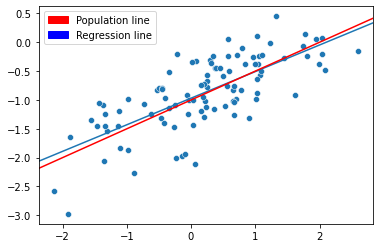

Polynomial regression: 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     55.31
Date:                Sat, 15 May 2021   Prob (F-statistic):           9.34e-17
Time:                        16:20:53   Log-Likelihood:                -57.561
No. Observations:                 100   AIC:                             121.1
Df Residuals:                      97   BIC:                             128.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9260      0.055    -16.727      0.0

In [35]:
q_15(0.25)

g) - The model with $x^2$ included has better fit statistics, but since we know that the true data generating process is linear we can be confident that this is just a function of fitting to some of the noise from $\epsilon$

h)

regardless of $\epsilon$, $beta_0 = -1$ and $beta_1 = 0.5$ and $y$ is a vector of length 100

Simple Linear Regression

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     212.1
Date:                Sat, 15 May 2021   Prob (F-statistic):           2.99e-26
Time:                        16:20:53   Log-Likelihood:                -27.246
No. Observations:                 100   AIC:                             58.49
Df Residuals:                      98   BIC:                             63.70
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0208      0.032    -31.529      0.0

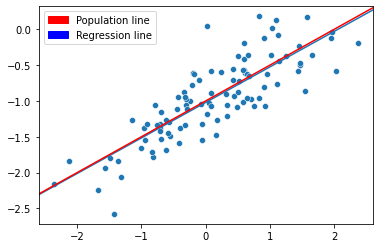

Polynomial regression: 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     111.9
Date:                Sat, 15 May 2021   Prob (F-statistic):           6.48e-26
Time:                        16:20:53   Log-Likelihood:                -25.044
No. Observations:                 100   AIC:                             56.09
Df Residuals:                      97   BIC:                             63.90
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9713      0.040    -24.482      0.0

In [36]:
q_15(0.1)

i)

regardless of $\epsilon$, $beta_0 = -1$ and $beta_1 = 0.5$ and $y$ is a vector of length 100

Simple Linear Regression

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     78.93
Date:                Sat, 15 May 2021   Prob (F-statistic):           3.18e-14
Time:                        16:20:53   Log-Likelihood:                -100.32
No. Observations:                 100   AIC:                             204.6
Df Residuals:                      98   BIC:                             209.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9688      0.067    -14.531      0.0

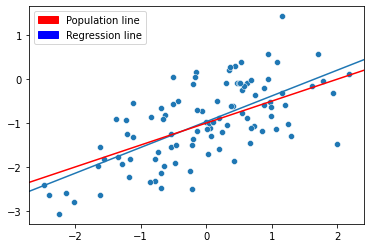

Polynomial regression: 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     42.66
Date:                Sat, 15 May 2021   Prob (F-statistic):           5.11e-14
Time:                        16:20:53   Log-Likelihood:                -98.303
No. Observations:                 100   AIC:                             202.6
Df Residuals:                      97   BIC:                             210.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8676      0.083    -10.459      0.0

In [37]:
q_15(0.5)

(j) What are the confidence intervals for $\beta_0$ and $\beta_1$ based on the original data set, the noisier data set, and the less noisy data set? Comment on your results.

As the data gets noisier, the confidence intervals for the coefficients get wider

### #14

This problem focuses on the collinearity problem.

(a) Perform the following commands in R :
```
set . seed (1)
x1 = runif (100)
x2 =0.5* x1 + rnorm (100) /10
y =2+2* x1 +0.3* x2 + rnorm (100)
```

The last line corresponds to creating a linear model in which y is a function of x1 and x2 . Write out the form of the linear model. What are the regression coefficients?

In [38]:
x1 = np.random.rand(100)
x2 = 0.5 * x1 + np.random.randn(100) / 100
y = 2 + 2*x1 + 0.3*x2 + np.random.randn(100)

$y = \beta_0 + \beta_1 x_1 + \beta_2x_2 + \epsilon$ where $\beta_0 = 2$, $\beta_1 = 2$ and $\beta_2 = 0.3$

(b) What is the correlation between x1 and x2 ? Create a scatterplot displaying the relationship between the variables.

In [39]:
np.corrcoef(x1, x2)

array([[1.        , 0.99718606],
       [0.99718606, 1.        ]])

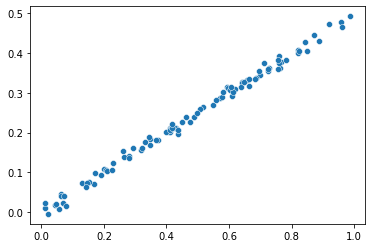

In [40]:
sns.scatterplot(x=x1, y=x2);

(c) Using this data, fit a least squares regression to predict $y$ using x1 and x2 . Describe the results obtained. What are $\hat{\beta_0}$, $\hat{\beta_1}$, and
$\hat{\beta_2}$? How do these relate to the true $\beta_0$, $\beta_1$, and $\beta_2$? Can you reject the null hypothesis $H_0 : \beta_1 = 0$? How about the null
hypothesis $H_0 : \beta_2 = 0$?

In [41]:
lm = sm.OLS(y, sm.add_constant(np.vstack([x1, x2]).T)).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     13.26
Date:                Sat, 15 May 2021   Prob (F-statistic):           8.09e-06
Time:                        16:20:53   Log-Likelihood:                -148.71
No. Observations:                 100   AIC:                             303.4
Df Residuals:                      97   BIC:                             311.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0804      0.228      9.118      0.0

The $\hat{\beta_0}$ estimate is pretty close, but the $\hat{\beta_1}$ and $\hat{\beta_2}$ estimates are way off. We also fail to reject $H_0$ for both of them.

(d) Now fit a least squares regression to predict y using only x1. Comment on your results. Can you reject the null hypothesis
$H_0 : \beta_1 = 0$?

In [42]:
lm = sm.OLS(y, sm.add_constant(x1)).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     22.52
Date:                Sat, 15 May 2021   Prob (F-statistic):           7.09e-06
Time:                        16:20:53   Log-Likelihood:                -150.46
No. Observations:                 100   AIC:                             304.9
Df Residuals:                      98   BIC:                             310.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1167      0.230      9.197      0.0

Results are much closer to the true model, and I can reject $H_0$

e) Now fit a least squares regression to predict y using only x2. Comment on your results. Can you reject the null hypothesis
$H_0 : \beta_1 = 0$?

In [43]:
lm = sm.OLS(y, sm.add_constant(x1)).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     22.52
Date:                Sat, 15 May 2021   Prob (F-statistic):           7.09e-06
Time:                        16:20:53   Log-Likelihood:                -150.46
No. Observations:                 100   AIC:                             304.9
Df Residuals:                      98   BIC:                             310.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1167      0.230      9.197      0.0

The coefficient on $x_2$ is close to the true value of the coefficient for $x_1$, and I can reject $H_0$

(f) Do the results obtained in (c)–(e) contradict each other? Explain your answer.

No, because $x_1$ and $x_2$ are so highly correlated, a model that includes both of them has no way of differentiating the marginal impact of a change in one on $y$ relative to a change in the other. As a result of this including both of them gets poor estimates for both. Including either one on its own is fine. To be able to include both we'd have to transform them to be closer to orthogonal to each other.

(g) Now suppose we obtain one additional observation, which was unfortunately mismeasured.
```
> x1 = c ( x1 , 0.1)
> x2 = c ( x2 , 0.8)
> y = c (y ,6)
```
Re-fit the linear models from (c) to (e) using this new data. What effect does this new observation have on the each of the models? In each model, is this observation an outlier? A high-leverage point? Both? Explain your answers.

In [44]:
x1 = np.append(x1, 0.1)
x2 = np.append(x2, 0.8)
y = np.append(y, 6)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     15.70
Date:                Sat, 15 May 2021   Prob (F-statistic):           1.22e-06
Time:                        16:20:53   Log-Likelihood:                -150.72
No. Observations:                 101   AIC:                             307.4
Df Residuals:                      98   BIC:                             315.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1005      0.229      9.179      0.0

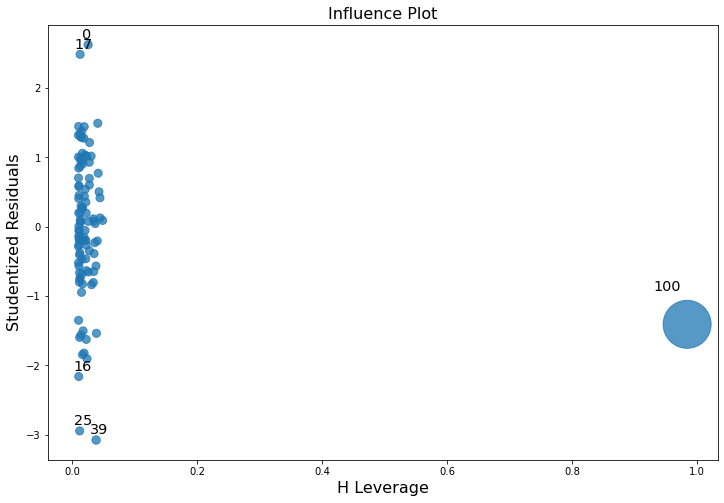

In [45]:
lm = sm.OLS(y, sm.add_constant(np.vstack([x1, x2]).T)).fit()
print(lm.summary())
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(lm, ax=ax, criterion="cooks")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     16.96
Date:                Sat, 15 May 2021   Prob (F-statistic):           7.91e-05
Time:                        16:20:54   Log-Likelihood:                -156.77
No. Observations:                 101   AIC:                             317.5
Df Residuals:                      99   BIC:                             322.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2476      0.238      9.455      0.0

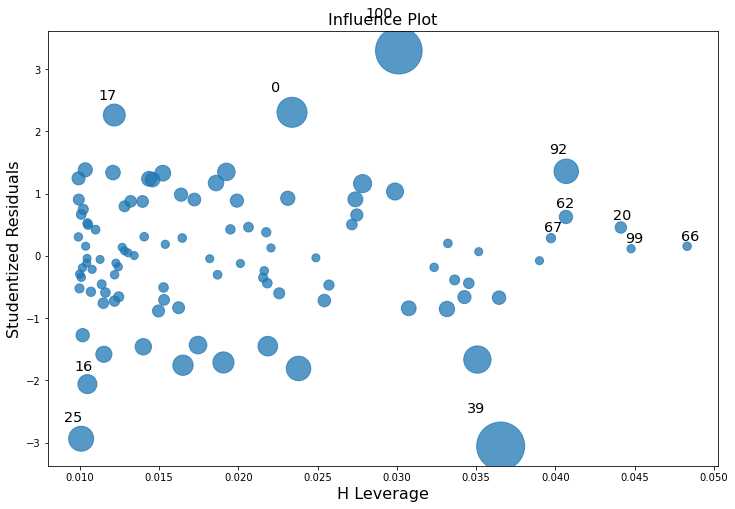

In [46]:
lm = sm.OLS(y, sm.add_constant(x1)).fit()
print(lm.summary())
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(lm, ax=ax, criterion="cooks")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     31.08
Date:                Sat, 15 May 2021   Prob (F-statistic):           2.15e-07
Time:                        16:20:54   Log-Likelihood:                -150.97
No. Observations:                 101   AIC:                             305.9
Df Residuals:                      99   BIC:                             311.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0527      0.218      9.431      0.0

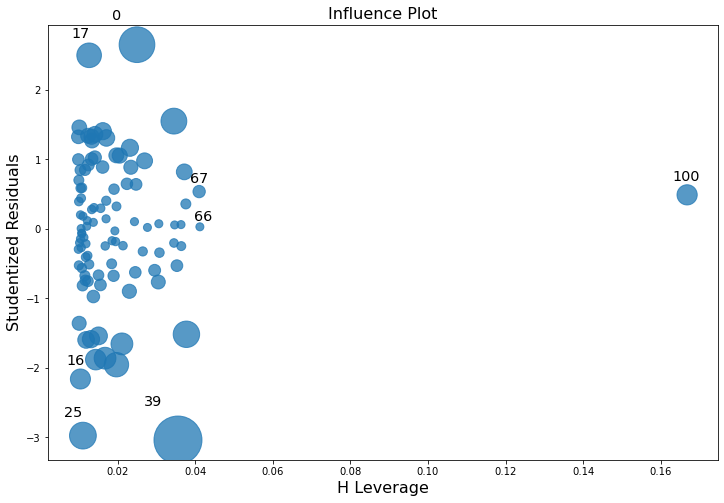

In [47]:
lm = sm.OLS(y, sm.add_constant(x2)).fit()
print(lm.summary())
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(lm, ax=ax, criterion="cooks")

Interestingly the appended observation is only clearly a high leverage observation in the models where $x_2$ is included. I'd describe it as an outlier regardless

### #15 

This problem involves the Boston data set, which we saw in the lab for this chapter. We will now try to predict per capita crime rate using the other variables in this data set. In other words, per capita crime rate is the response, and the other variables are the predictors. 

(a) For each predictor, fit a simple linear regression model to predict the response. Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create some plots to back up your assertions. 

In [48]:
df = sm.datasets.get_rdataset("Boston", "MASS", cache=True).data

In [49]:
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


For simplicity I'm going to treat all of these variables as if they're continuous, but it looks like some of them are ordinal or categorical

                            OLS Regression Results                            
Dep. Variable:                   crim   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     21.10
Date:                Sat, 15 May 2021   Prob (F-statistic):           5.51e-06
Time:                        16:20:54   Log-Likelihood:                -1796.0
No. Observations:                 506   AIC:                             3596.
Df Residuals:                     504   BIC:                             3604.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4537      0.417     10.675      0.0

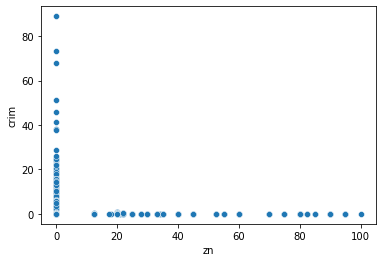

                            OLS Regression Results                            
Dep. Variable:                   crim   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     99.82
Date:                Sat, 15 May 2021   Prob (F-statistic):           1.45e-21
Time:                        16:20:54   Log-Likelihood:                -1760.6
No. Observations:                 506   AIC:                             3525.
Df Residuals:                     504   BIC:                             3534.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0637      0.667     -3.093      0.0

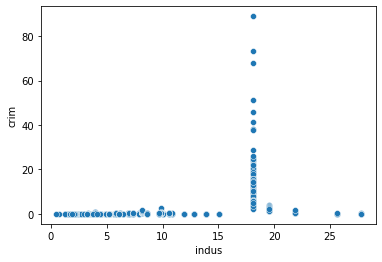

                            OLS Regression Results                            
Dep. Variable:                   crim   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.579
Date:                Sat, 15 May 2021   Prob (F-statistic):              0.209
Time:                        16:20:54   Log-Likelihood:                -1805.6
No. Observations:                 506   AIC:                             3615.
Df Residuals:                     504   BIC:                             3624.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7444      0.396      9.453      0.0

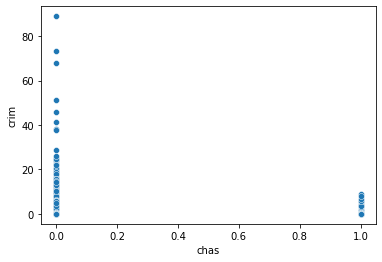

                            OLS Regression Results                            
Dep. Variable:                   crim   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     108.6
Date:                Sat, 15 May 2021   Prob (F-statistic):           3.75e-23
Time:                        16:20:54   Log-Likelihood:                -1757.0
No. Observations:                 506   AIC:                             3518.
Df Residuals:                     504   BIC:                             3526.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -13.7199      1.699     -8.073      0.0

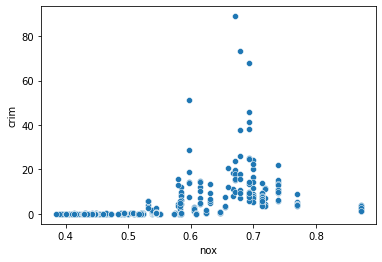

                            OLS Regression Results                            
Dep. Variable:                   crim   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     25.45
Date:                Sat, 15 May 2021   Prob (F-statistic):           6.35e-07
Time:                        16:20:54   Log-Likelihood:                -1793.9
No. Observations:                 506   AIC:                             3592.
Df Residuals:                     504   BIC:                             3600.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.4818      3.364      6.088      0.0

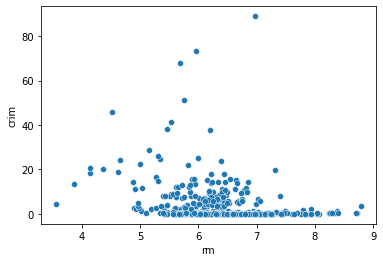

                            OLS Regression Results                            
Dep. Variable:                   crim   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     71.62
Date:                Sat, 15 May 2021   Prob (F-statistic):           2.85e-16
Time:                        16:20:54   Log-Likelihood:                -1772.7
No. Observations:                 506   AIC:                             3549.
Df Residuals:                     504   BIC:                             3558.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.7779      0.944     -4.002      0.0

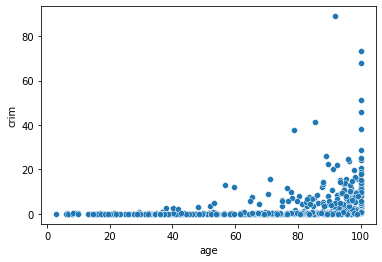

                            OLS Regression Results                            
Dep. Variable:                   crim   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     84.89
Date:                Sat, 15 May 2021   Prob (F-statistic):           8.52e-19
Time:                        16:20:55   Log-Likelihood:                -1767.0
No. Observations:                 506   AIC:                             3538.
Df Residuals:                     504   BIC:                             3546.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4993      0.730     13.006      0.0

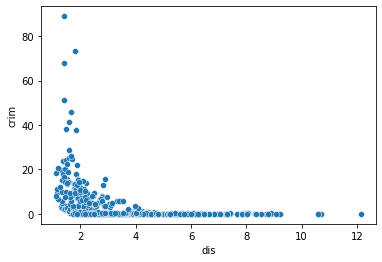

                            OLS Regression Results                            
Dep. Variable:                   crim   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     323.9
Date:                Sat, 15 May 2021   Prob (F-statistic):           2.69e-56
Time:                        16:20:55   Log-Likelihood:                -1680.8
No. Observations:                 506   AIC:                             3366.
Df Residuals:                     504   BIC:                             3374.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2872      0.443     -5.157      0.0

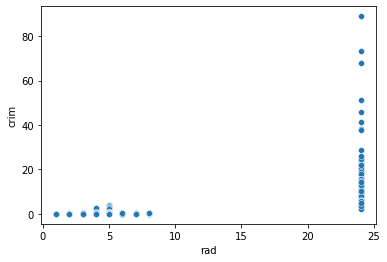

                            OLS Regression Results                            
Dep. Variable:                   crim   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     259.2
Date:                Sat, 15 May 2021   Prob (F-statistic):           2.36e-47
Time:                        16:20:55   Log-Likelihood:                -1701.4
No. Observations:                 506   AIC:                             3407.
Df Residuals:                     504   BIC:                             3415.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.5284      0.816    -10.454      0.0

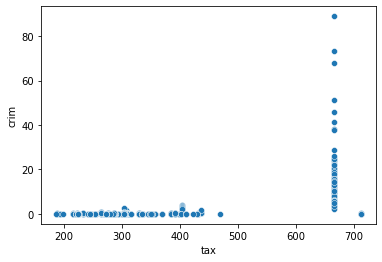

                            OLS Regression Results                            
Dep. Variable:                   crim   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     46.26
Date:                Sat, 15 May 2021   Prob (F-statistic):           2.94e-11
Time:                        16:20:55   Log-Likelihood:                -1784.1
No. Observations:                 506   AIC:                             3572.
Df Residuals:                     504   BIC:                             3581.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.6469      3.147     -5.607      0.0

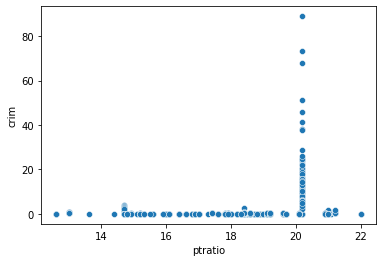

                            OLS Regression Results                            
Dep. Variable:                   crim   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     87.74
Date:                Sat, 15 May 2021   Prob (F-statistic):           2.49e-19
Time:                        16:20:55   Log-Likelihood:                -1765.8
No. Observations:                 506   AIC:                             3536.
Df Residuals:                     504   BIC:                             3544.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.5535      1.426     11.609      0.0

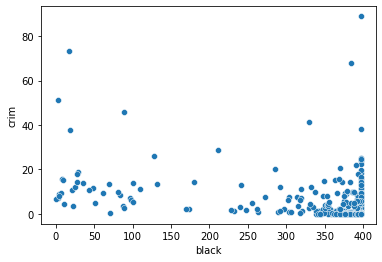

                            OLS Regression Results                            
Dep. Variable:                   crim   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     132.0
Date:                Sat, 15 May 2021   Prob (F-statistic):           2.65e-27
Time:                        16:20:55   Log-Likelihood:                -1747.5
No. Observations:                 506   AIC:                             3499.
Df Residuals:                     504   BIC:                             3507.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3305      0.694     -4.801      0.0

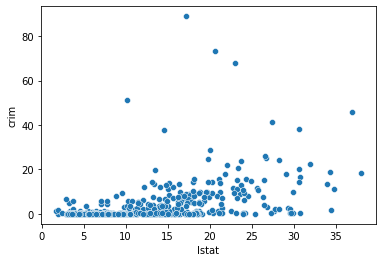

                            OLS Regression Results                            
Dep. Variable:                   crim   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     89.49
Date:                Sat, 15 May 2021   Prob (F-statistic):           1.17e-19
Time:                        16:20:55   Log-Likelihood:                -1765.0
No. Observations:                 506   AIC:                             3534.
Df Residuals:                     504   BIC:                             3542.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.7965      0.934     12.628      0.0

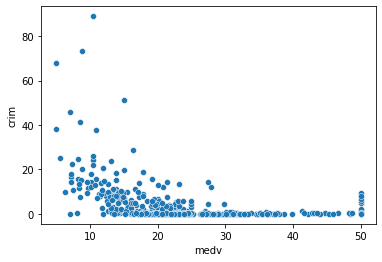

In [50]:
y = df["crim"]
xs = [col for col in df.columns if col != "crim"]
for x in xs:
    lm = sm.OLS(y, sm.add_constant(df[x])).fit()
    print(lm.summary())
    sns.scatterplot(x=x, y="crim", data=df);
    plt.show()
    plt.close()

All of the hypothesis tests except for chas suggest statistical significance, but looking at the scatter plots the relationship is clearly non-linear. As mentioned above, a lot of these variables look like they're categorical, so doing a regression on them as if they're continuous is bad practice. In general, despite the decent fit statistics I don't like the look of these models

(b) Fit a multiple regression model to predict the response using all of the predictors. Describe your results. For which predictors can we reject the null hypothesis $H_0 : \beta_j = 0$?

In [51]:
lm_all = sm.OLS(y, sm.add_constant(df[xs])).fit()
print(lm_all.summary())

                            OLS Regression Results                            
Dep. Variable:                   crim   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     31.47
Date:                Sat, 15 May 2021   Prob (F-statistic):           1.57e-56
Time:                        16:20:55   Log-Likelihood:                -1653.3
No. Observations:                 506   AIC:                             3335.
Df Residuals:                     492   BIC:                             3394.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.0332      7.235      2.354      0.0

(c) How do your results from (a) compare to your results from (b)? Create a plot displaying the univariate regression coefficients from (a) on the x-axis, and the multiple regression coefficients from (b) on the y-axis. That is, each predictor is displayed as a single point in the plot. Its coefficient in a simple linear regression model is shown on the x-axis, and its coefficient estimate in the multiple linear regression model is shown on the y-axis.

In the multiple regression model we find zn, nox, dis, rad, black, lstat, and medv significant at the 5% level.

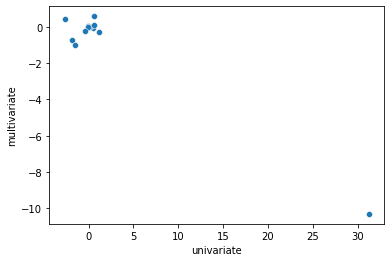

In [52]:
param_df = pd.DataFrame()
for col in xs:
    lm = sm.OLS(y, sm.add_constant(df[col])).fit()
    param_df.loc[col, "univariate"] = lm.params.loc[col]
    param_df.loc[col, "multivariate"] = lm_all.params.loc[col]
sns.scatterplot(x="univariate", y="multivariate", data=param_df);

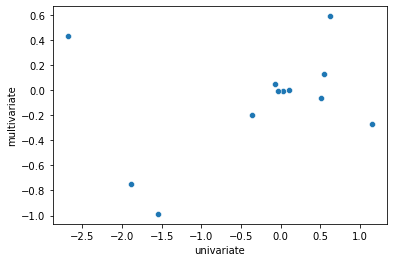

In [53]:
sns.scatterplot(x="univariate", y="multivariate", data=param_df.drop("nox"));

(d) Is there evidence of non-linear association between any of the predictors and the response? To answer this question, for each predictor $X$, fit a model of the form $Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \epsilon$.

I mean looking at the scatter plots from before there's obvious non-linearity, but sure, let's try this too

In [54]:
for col in xs:
    for quad in range(2,4):
        new_col = col + "_pow" + str(quad)
        df[new_col] = df[col]**quad
for col in xs:
    cols = [col, col + "_pow2", col + "_pow3"]
    X = sm.add_constant(df[cols])
    lm = sm.OLS(y, X).fit()
    print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                   crim   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     10.35
Date:                Sat, 15 May 2021   Prob (F-statistic):           1.28e-06
Time:                        16:20:56   Log-Likelihood:                -1791.2
No. Observations:                 506   AIC:                             3590.
Df Residuals:                     502   BIC:                             3607.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8461      0.433     11.192      0.0

Sure, some of these look like they fit better, but again, looking at the scatter plots...